In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m')

In [3]:
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], date_parser=dateparse)
df = df.rename({'Month': 'month', '#Passengers': 'passengers'}, axis=1) 
df

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [4]:
#Check missing value
df.isna().sum()

month         0
passengers    0
dtype: int64

In [5]:
#Check data type
df.dtypes

month         datetime64[ns]
passengers             int64
dtype: object

In [6]:
df = df.groupby('month').sum('passengers')

In [7]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

In [8]:
y = df.resample('MS').mean()

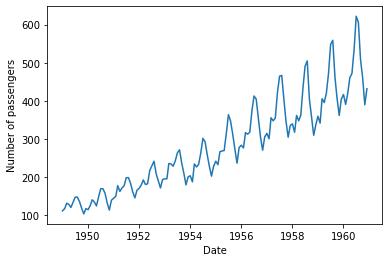

In [9]:
#Plot the data
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.plot(df)

<Figure size 1296x576 with 0 Axes>

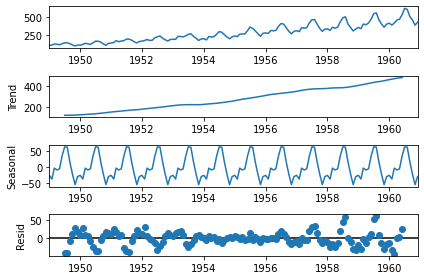

In [10]:
# decomposition
plt.figure(figsize=(18,8))
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

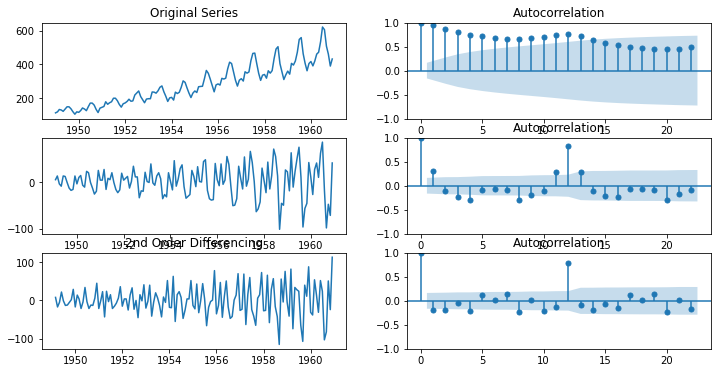

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12, 6))

#原始資料
axs[0, 0].plot(df)
axs[0, 0].set_title('Original Series')
plot_acf(df, ax=axs[0, 1])

# 一階差分
axs[1, 0].plot(df.diff())
#axs[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axs[1, 1])

# 二階差分
axs[2, 0].plot(df.diff().diff())
axs[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axs[2, 1])

plt.show()

In [12]:
# train test split
import math
n = math.floor(len(df)*0.8)
train = df[:n]
test = df[n:]

# SARIMA model
The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
tuning = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        print(param, param_seasonal)
        mod = sm.tsa.statespace.SARIMAX(train,
                                order=param,
                                seasonal_order=param_seasonal)
        results = mod.fit()
        
        
        y_pred = results.predict(start = test.index[0] , end = test.index[-1], dynamic= True)
        predictions = pd.Series(y_pred)
        mape = mean_absolute_percentage_error(test, predictions)
        tuning.append([param, param_seasonal, results.aic, mape])

(0, 0, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96648D+00    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.776D-10   6.966D+00
  F =   6.9664817206126504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 0) (0, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are e

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/pytho


At iterate    5    f=  4.27897D+00    |proj g|=  6.73278D-02

At iterate   10    f=  4.20472D+00    |proj g|=  2.42789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     14      1     0     0   4.882D-06   4.205D+00
  F =   4.2047037877592874     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 0) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40997D+02    |proj g|=  2.37575D+02

At iterate    5    f=  9.15958D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianh


At iterate   15    f=  4.95610D+00    |proj g|=  1.09055D-02

At iterate   20    f=  4.94120D+00    |proj g|=  1.03600D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   3.481D-06   4.941D+00
  F =   4.9411894518165322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 0) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00833D+00    |proj g|=  4.04660D-02

At iterate    5    f=  3.99865D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.91391D+00    |proj g|=  3.99773D-02

At iterate   15    f=  3.91074D+00    |proj g|=  2.53993D-03

At iterate   20    f=  3.91066D+00    |proj g|=  4.71862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     22      1     0     0   1.950D-06   3.911D+00
  F =   3.9106554533561053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96654D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/


At iterate   10    f=  5.90516D+00    |proj g|=  2.37207D-01

At iterate   15    f=  5.80993D+00    |proj g|=  9.40724D-03

At iterate   20    f=  5.80470D+00    |proj g|=  3.65099D-04

At iterate   25    f=  5.80431D+00    |proj g|=  1.04543D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     37      1     0     0   7.775D-06   5.804D+00
  F =   5.8043017803904871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactl

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   1.166D-06   3.889D+00
  F =   3.8890520957234256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 0, 1) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96654D+00    |proj g|=  9.63356D-01

At iterate    5    f=  6.53726D+00    |proj g|=  6.36371D-03

At iterate   10    f=  5.23525D+00    |proj g|=  5.16628D-01

At iterate   15    f=  4.79359D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is u

(0, 0, 1) (1, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62275D+00    |proj g|=  2.25800D+00

At iterate    5    f=  6.53600D+00    |proj g|=  1.04829D-02

At iterate   10    f=  5.85141D+00    |proj g|=  3.74784D-01

At iterate   15    f=  4.66550D+00    |proj g|=  1.12219D-01

At iterate   20    f=  4.65577D+00    |proj g|=  1.56857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     38      1     0     0   3.327D-06   4.656D+00
  F =   4.655760

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.93740D+00    |proj g|=  7.06707D-02

At iterate   10    f=  3.68447D+00    |proj g|=  3.27491D-02

At iterate   15    f=  3.67487D+00    |proj g|=  1.88759D-02

At iterate   20    f=  3.67060D+00    |proj g|=  2.45839D-03

At iterate   25    f=  3.66981D+00    |proj g|=  2.20475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   4.812D-03   3.670D+00
  F =   3.6697952552430477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred 

(0, 1, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67076D+00    |proj g|=  3.24448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   6.346D-07   4.671D+00
  F =   4.6707442943491824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 0) (0, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are e

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/pytho

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62666D+01    |proj g|=  2.16685D+01

At iterate    5    f=  3.87415D+00    |proj g|=  1.50228D-01

At iterate   10    f=  3.76854D+00    |proj g|=  1.48978D-02

At iterate   15    f=  3.76767D+00    |proj g|=  4.56838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   7.216D-06   3.768D+00
  F =   3.7676680540720189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 0

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.27403D+00    |proj g|=  2.01981D-02

At iterate   10    f=  3.27360D+00    |proj g|=  3.26727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   3.911D-06   3.274D+00
  F =   3.2735733279060435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61106D+00    |proj g|=  5.24025D-02

At iterate    5    f=  4.60770D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/


At iterate    5    f=  4.29511D+00    |proj g|=  8.92892D-02

At iterate   10    f=  4.26272D+00    |proj g|=  2.06065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.765D-06   4.263D+00
  F =   4.2626761651874823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27015D+00    |proj g|=  1.22280D-02

At iterate    5    f=  3.26962D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/pytho


At iterate    5    f=  3.26253D+00    |proj g|=  3.25213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.358D-06   3.263D+00
  F =   3.2625229644052034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 1) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61106D+00    |proj g|=  7.38317D-01

At iterate    5    f=  4.21067D+00    |proj g|=  5.59833D-02

At iterate   10    f=  3.82692D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  3.77062D+00    |proj g|=  4.47209D-02

At iterate   25    f=  3.76246D+00    |proj g|=  6.02541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   4.243D-06   3.762D+00
  F =   3.7624601396611368     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(0, 1, 1) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26337D+00    |proj g|=  3.44429D-02

At iterate    5    f=  3.26185D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.26164D+00    |proj g|=  1.66719D-02

At iterate   10    f=  3.26133D+00    |proj g|=  8.77898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   3.400D-06   3.261D+00
  F =   3.2613342475450171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00500D+01    |proj g|=  8.96504D+01

At iterate    5    f=  5.29491D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Us


           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00500D+01    |proj g|=  8.96504D+01

At iterate    5    f=  4.90898D+00    |proj g|=  7.90297D-01

At iterate   10    f=  4.51036D+00    |proj g|=  3.09627D-02

At iterate   15    f=  4.35592D+00    |proj g|=  2.96532D-03

At iterate   20    f=  4.35559D+00    |proj g|=  1.73794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   8.924D-06   4.356D+00
  F =   4.3555330298998642     

CONVERGENCE: NORM_OF_PROJECTED_GR

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/pytho


At iterate   20    f=  3.84298D+00    |proj g|=  5.24567D-03

At iterate   25    f=  3.82442D+00    |proj g|=  5.01646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     37      1     0     0   1.423D-06   3.824D+00
  F =   3.8238529588812189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 0) (1, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10272D+02    |proj g|=  2.07085D+02

At iterate    5    f=  4.69097D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 


At iterate   30    f=  3.81641D+00    |proj g|=  4.14756D-03

At iterate   35    f=  3.81605D+00    |proj g|=  9.00520D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     43      1     0     0   9.005D-06   3.816D+00
  F =   3.8160538974926093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 0) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75914D+00    |proj g|=  1.75971D-01


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.30851D+00    |proj g|=  6.41303D-03

At iterate   10    f=  3.30650D+00    |proj g|=  1.91157D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     24      1     0     0   2.902D-06   3.306D+00
  F =   3.3064864049570781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 0) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35178D+00    |proj g|=  1.51279D-01

At iterate    5    f=  3.31445D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.31033D+00    |proj g|=  1.33030D-03

At iterate   15    f=  3.30934D+00    |proj g|=  1.64397D-03

At iterate   20    f=  3.30882D+00    |proj g|=  3.09136D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No fre


At iterate   25    f=  3.30874D+00    |proj g|=  8.85762D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   8.858D-05   3.309D+00
  F =   3.3087447893909010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(1, 0, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23853D+01    |proj g|=  5.49796D+01

At iterate    5    f=  4.97117D+00    |proj g|=  5.16598D-01

At iterate   10    f=  4.68987D+00    |proj g

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42671D+00    |proj g|=  4.63611D-01

At iterate    5    f=  3.29692D+00    |proj g|=  6.36006D-03

At iterate   10    f=  3.29682D+00    |proj g|=  1.68559D-03

At iterate   15    f=  3.29681D+00    |proj g|=  1.61376D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.030D-06   3.297D+00
  F =   3.2968065915543860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 1

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23853D+01    |proj g|=  5.49796D+01

At iterate    5    f=  4.49330D+00    |proj g|=  2.60896D-01

At iterate   10    f=  4.28580D+00    |proj g|=  3.31523D-02

At iterate   15    f=  3.83560D+00    |proj g|=  8.92420D-03

At iterate   20    f=  3.83345D+00    |proj g|=  5.55990D-03

At iterate   25    f=  3.81768D+00    |proj g|=  9.31568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 


At iterate   20    f=  3.83150D+00    |proj g|=  6.90330D-03

At iterate   25    f=  3.82750D+00    |proj g|=  5.14379D-03

At iterate   30    f=  3.82418D+00    |proj g|=  6.32707D-02

At iterate   35    f=  3.81235D+00    |proj g|=  1.48731D-02

At iterate   40    f=  3.81194D+00    |proj g|=  2.30434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     58      1     0     0   1.612D-05   3.812D+00
  F =   3.8119392563855170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(1, 0, 1) (1, 1, 0, 12)


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70900D+00    |proj g|=  2.00186D-01

At iterate    5    f=  3.31882D+00    |proj g|=  1.25488D-01

At iterate   10    f=  3.29678D+00    |proj g|=  3.38651D-02

At iterate   15    f=  3.29593D+00    |proj g|=  7.46398D-04

At iterate   20    f=  3.29592D+00    |proj g|=  1.35225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   6.903D-06   3.296D+00
  F =   3.2959229146218609     

CONVERG

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.29013D+00    |proj g|=  5.24178D-03

At iterate   20    f=  3.28961D+00    |proj g|=  9.80612D-04

At iterate   25    f=  3.28940D+00    |proj g|=  8.50121D-04

At iterate   30    f=  3.28939D+00    |proj g|=  6.91508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     49      1     0     0   2.822D-04   3.289D+00
  F =   3.2893878361215876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(1, 1, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactl

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/

(1, 1, 0) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26740D+00    |proj g|=  1.30394D-03

At iterate    5    f=  3.26739D+00    |proj g|=  1.18641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   5.862D-07   3.267D+00
  F =   3.2673885458941450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 1, 0) (0, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62844D+00    |proj g|=  7.78702D-01

At iterate    5    f=  3.95946D+00    |proj g|=  9.76015D-02

At iterate   10    f=  3.81414D+00    |proj g|=  1.18747D-02

At iterate   15    f=  3.77452D+00    |proj g|=  2.43916D-02

At iterate   20    f=  3.76785D+00    |proj g|=  6.94063D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     34      1     0     0   6.941D-06   3.768D+00
  F =   3.7678539413465453     

CONVERG

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  4.27284D+00    |proj g|=  3.13355D-02

At iterate   10    f=  3.85821D+00    |proj g|=  1.56830D-01

At iterate   15    f=  3.80772D+00    |proj g|=  1.88224D-02

At iterate   20    f=  3.76529D+00    |proj g|=  3.97941D-02

At iterate   25    f=  3.76170D+00    |proj g|=  2.07885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.079D-05   3.762D+00
  F =   3.7617031399633274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(1, 1, 0) (1, 1, 0, 12)


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26128D+00    |proj g|=  3.98758D-02

At iterate    5    f=  3.25979D+00    |proj g|=  2.63528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   5.511D-07   3.260D+00
  F =   3.2597837869742810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 1, 0) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.25067D+00    |proj g|=  1.91858D-02

At iterate   15    f=  4.24198D+00    |proj g|=  2.18215D-03

At iterate   20    f=  4.24159D+00    |proj g|=  3.67262D-04

At iterate   25    f=  4.24156D+00    |proj g|=  6.89608D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   6.896D-06   4.242D+00
  F =   4.2415630256932939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 1, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactl

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


(1, 1, 1) (0, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26183D+00    |proj g|=  2.06734D-02

At iterate    5    f=  3.25600D+00    |proj g|=  2.38288D-02

At iterate   10    f=  3.25491D+00    |proj g|=  3.47566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   3.296D-06   3.255D+00
  F =   3.2549065910330381     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 1, 1) (1, 0, 0, 12)
RUNNING THE L-BFGS-B C

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianh

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60783D+00    |proj g|=  2.43239D+00

At iterate    5    f=  4.26894D+00    |proj g|=  3.13749D-02

At iterate   10    f=  3.84739D+00    |proj g|=  1.86357D-01

At iterate   15    f=  3.79844D+00    |proj g|=  5.52835D-02

At iterate   20    f=  3.76276D+00    |proj g|=  3.30625D-02

At iterate   25    f=  3.75730D+00    |proj g|=  2.61012D-02

At iterate   30    f=  3.73570D+00    |proj g|=  8.92416D-03

At iterate   35    f=  3.73497D+00    |proj g|=  3.89345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.25399D+00    |proj g|=  2.63156D-02

At iterate   10    f=  3.25331D+00    |proj g|=  2.35082D-04

At iterate   15    f=  3.25331D+00    |proj g|=  6.40834D-05

At iterate   20    f=  3.25331D+00    |proj g|=  8.34158D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.928D-06   3.253D+00
  F =   3.2533052060510674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [15]:
df_tuning = pd.DataFrame(tuning, columns=['param','param_season','AIC','MAPE'])
df_tuning.sort_values('MAPE')

,param,param_season,AIC,MAPE
19,"(0, 1, 0)","(0, 1, 1, 12)",756.988163,0.044876
23,"(0, 1, 0)","(1, 1, 1, 12)",758.921865,0.044890
22,"(0, 1, 0)","(1, 1, 0, 12)",756.959164,0.045224
7,"(0, 0, 0)","(1, 1, 1, 12)",905.450754,0.045995
21,"(0, 1, 0)","(1, 0, 1, 12)",872.563652,0.046823
...,...,...,...,...
48,"(1, 1, 0)","(0, 0, 0, 12)",1068.535806,0.236892
9,"(0, 0, 1)","(0, 0, 1, 12)",1340.989409,0.800906
1,"(0, 0, 0)","(0, 0, 1, 12)",1489.788436,0.815803
8,"(0, 0, 1)","(0, 0, 0, 12)",1455.244344,0.982686


# Final model

In [17]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27511D+00    |proj g|=  3.08692D-02

At iterate    5    f=  3.27386D+00    |proj g|=  1.30359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   5.448D-07   3.274D+00
  F =   3.2738615787478511     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           passengers   No. Observations:                  115
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -376.494
Date:                              Thu, 07 Apr 2022   AIC                            756.988
Time:                                      16:24:53   BIC                            762.238
Sample:                                  01-01-1949   HQIC                           759.114
                                       - 07-01-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1648      0.091     -1.808      0.071      -0.343       0.014
sigma2        93.7960     14.503      6.467      0.000      65.371     122.221
===================================================================================
Ljung-Box (L1) (Q):                   2.78   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.10   Prob(JB):                         0.36
Heteroskedasticity (H):               0.96   Skew:                             0.30
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
y_pred = results.predict(start = test.index[0] , end = test.index[-1], dynamic= True)

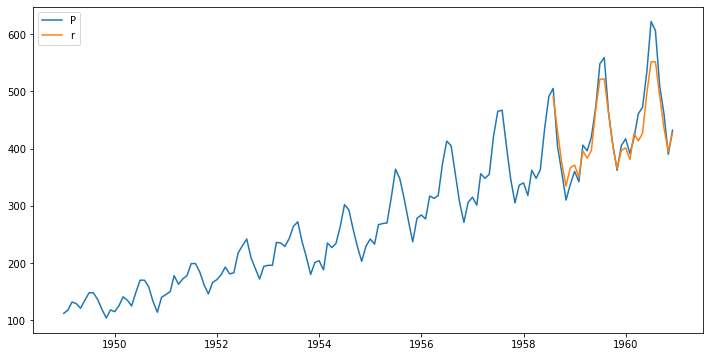

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df, label='passengers')
plt.plot(y_pred)
plt.legend('Predicted')

In [21]:
# save predicted results to csv
predictions.to_csv('submission.csv')